<a href="https://colab.research.google.com/github/ursu-mihai77777/Arduiuno/blob/main/Medical_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:

import numpy as np
import pandas as pd



from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install split-folders
!pip install torch-summary

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')

import copy
import os


from PIL import Image

import pathlib

from sklearn.metrics import confusion_matrix, classification_report

import itertools

from tqdm.notebook import trange,tqdm
import warnings
warnings.filterwarnings('ignore')

In [93]:
labels_df=pd.read_csv('/content/drive/MyDrive/ML/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [94]:
labels_df.shape

(4600, 6)

In [95]:
import pathlib
import splitfolders
# Dataset Path
data_dir = '/content/drive/MyDrive/ML/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain_data', seed=20, ratio=(0.8, 0.2))


TRAIN_DIR = 'brain_data/train'
VAL_DIR = 'brain_data/val'

data_dir = '/content/brain_data'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [01:25, 53.69 files/s] 


In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    # Poți adăuga și altele dacă vrei:
    # zoom_range=0.1,
    # width_shift_range=0.1
)


val_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3679 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


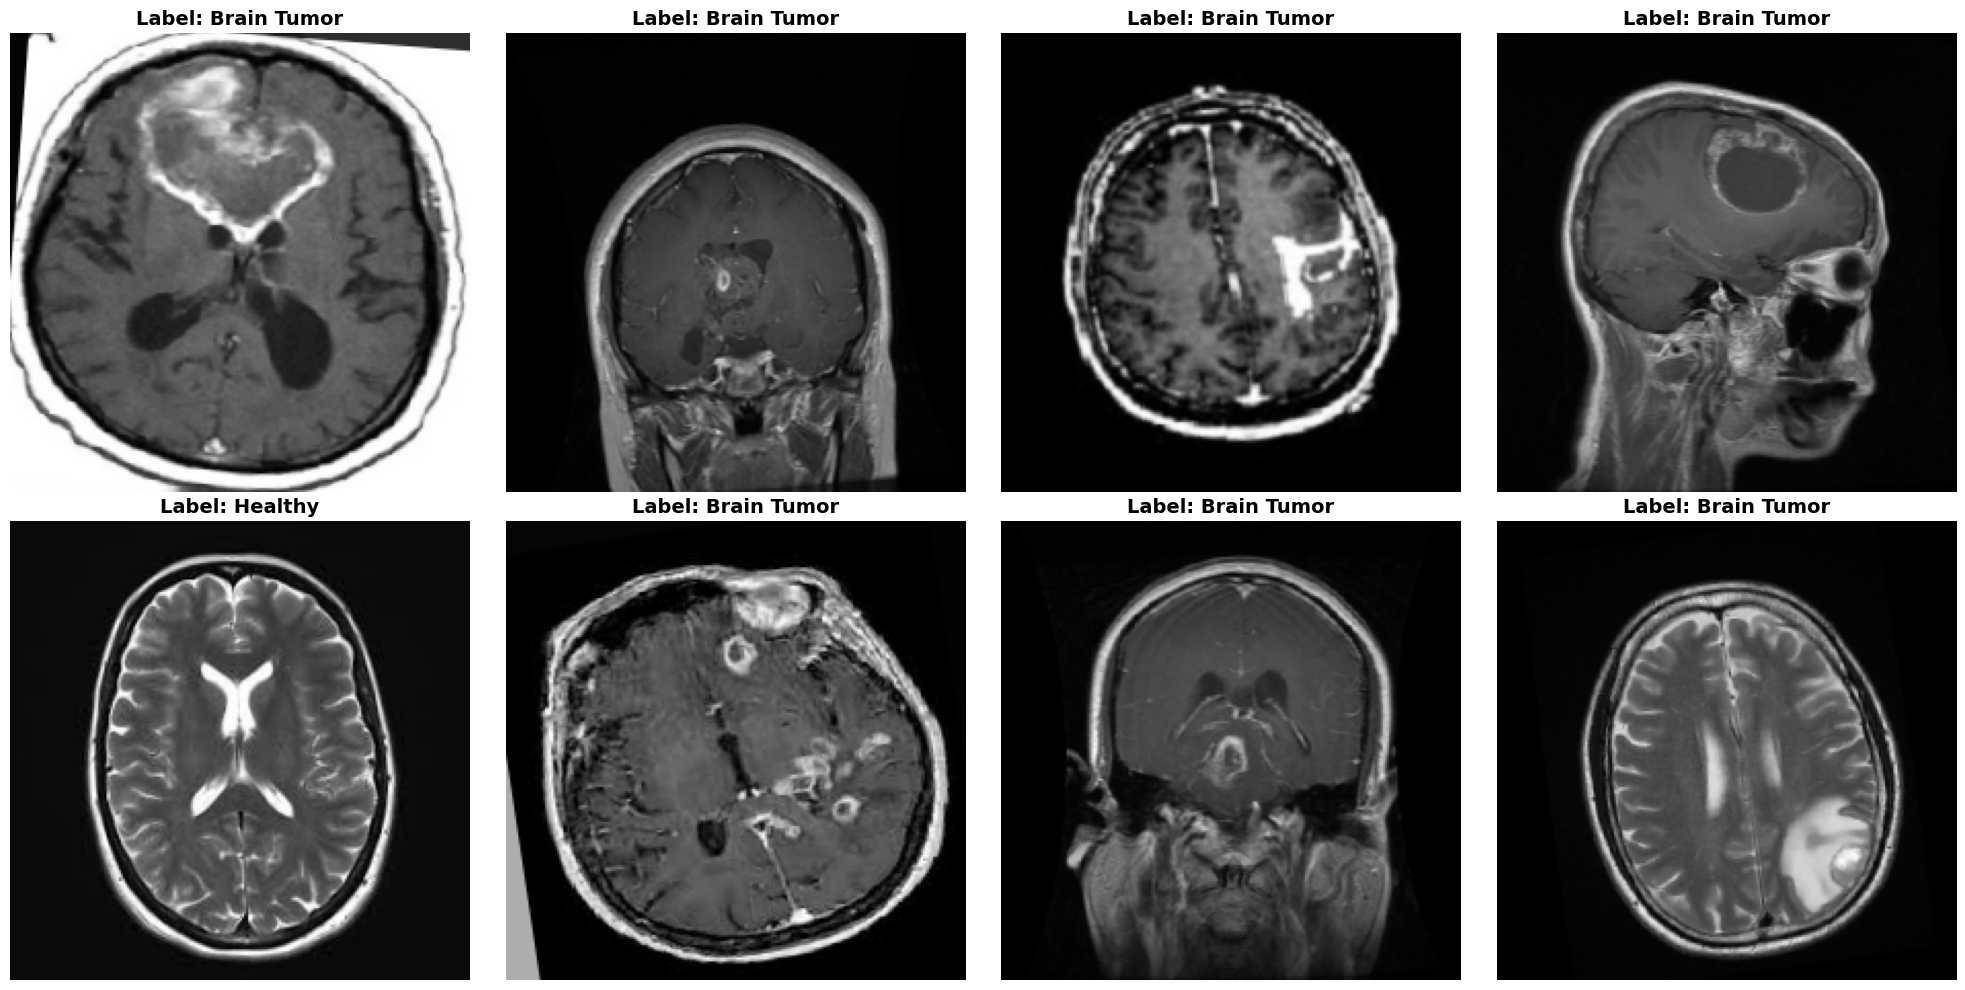

In [97]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)


class_dict = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(20, 10))

for i in range(8): #
    ax = plt.subplot(2, 4, i + 1)


    plt.imshow(images[i])


    label_index = int(labels[i])


    label_name = class_dict[label_index]

    plt.title(f"Label: {label_name}", color='black', fontsize=14, fontweight='bold')


    plt.axis("off") #

plt.tight_layout()
plt.show()

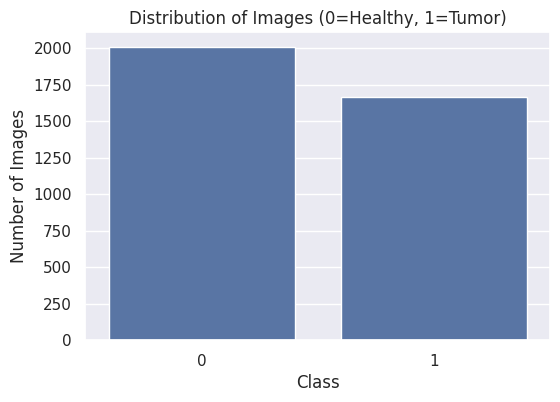

Number of Images Healthy (0): 2010
Number of Images Tumor (1): 1669


In [98]:

import seaborn as sns


real_labels = train_generator.classes


plt.figure(figsize=(6, 4))
sns.countplot(x=real_labels)
plt.title('Distribution of Images (0=Healthy, 1=Tumor)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

print("Number of Images Healthy (0):", len(real_labels[real_labels == 0]))
print("Number of Images Tumor (1):", len(real_labels[real_labels == 1]))

In [99]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation ='relu', input_shape =(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation ='relu'))
model.add(layers.Dense(1, activation ="sigmoid"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
from keras import optimizers

model.compile(loss ="binary_crossentropy", optimizer = optimizers.RMSprop(), metrics =['accuracy'])

history = model.fit(train_generator, steps_per_epoch = 100, epochs = 12, validation_data = validation_generator, validation_steps = 50)

Epoch 1/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.6047 - loss: 0.7148 - val_accuracy: 0.7698 - val_loss: 0.4810
Epoch 2/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 854ms/step - accuracy: 0.7433 - loss: 0.5276 - val_accuracy: 0.5809 - val_loss: 1.2049
Epoch 3/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.8045 - loss: 0.4517 - val_accuracy: 0.8371 - val_loss: 0.3467
Epoch 4/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 847ms/step - accuracy: 0.8224 - loss: 0.3868 - val_accuracy: 0.7850 - val_loss: 0.4441
Epoch 5/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.8562 - loss: 0.3193 - val_accuracy: 0.8925 - val_loss: 0.2558
Epoch 6/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 851ms/step - accuracy: 0.8955 - loss: 0.2627 - val_accuracy: 0.9131 - val_loss: 0.2114
Epoch 7/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.9108 - loss: 0.2048 - val_accuracy: 0.9349 - val_loss: 0.1607
Epoch 8/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 859ms/step - accuracy: 0.9216 - loss: 0.1813 - 

(1, 224, 224, 3)


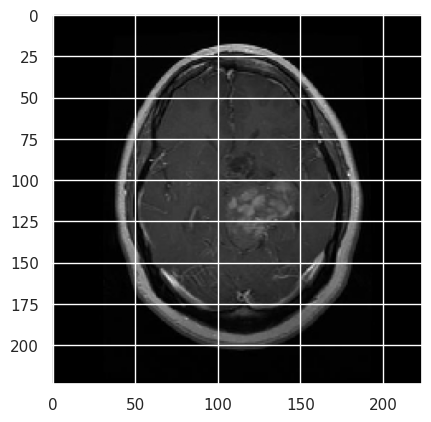

In [101]:
from keras.preprocessing import image
import numpy as np


image_path = data_dir / 'train' / 'Brain Tumor' / 'Cancer (1).jpg'


img = image.load_img(image_path, target_size = (224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.


print(img_tensor.shape)


import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 222, 222, 32)


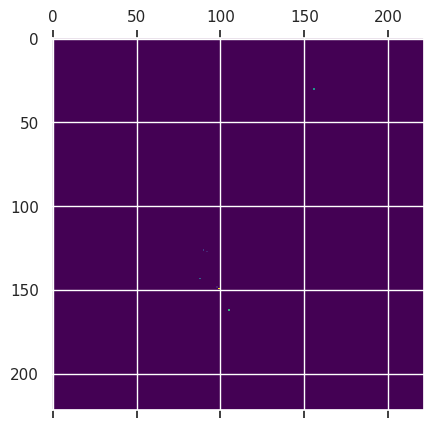

In [108]:
import numpy as np # Ensure numpy is imported for array operations
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# Ensure the model is built before accessing its input
# The input shape should match the input expected by the model (150, 150, 3) plus a batch dimension (None)
if not model.built:
    model.build(input_shape=(None, 150, 150, 3))


if 'train_generator' in locals():
    images, _ = next(train_generator)
    img_tensor = np.expand_dims(images[0], axis=0)
else:
    print("Error: 'train_generator' is not defined. Please run the cell where it is initialized.")

    img_tensor = np.random.rand(1, 224, 224, 3).astype('float32')

# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.layers[0].input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)


first_layer_activation = activations[0]

# shape of first layer activation
print(first_layer_activation.shape)


plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis')


plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

In [103]:
layer_names = []

for layer in model.layers[:8]:
  layer_names.append(layer.name)
print(layer_names)

['conv2d_40', 'max_pooling2d_8', 'conv2d_41', 'max_pooling2d_9', 'conv2d_42', 'max_pooling2d_10', 'conv2d_43', 'max_pooling2d_11']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


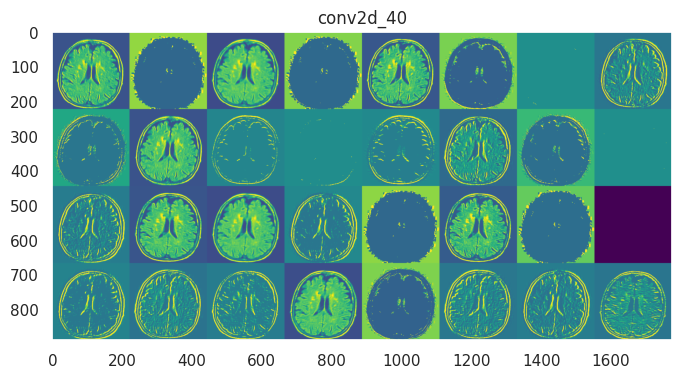

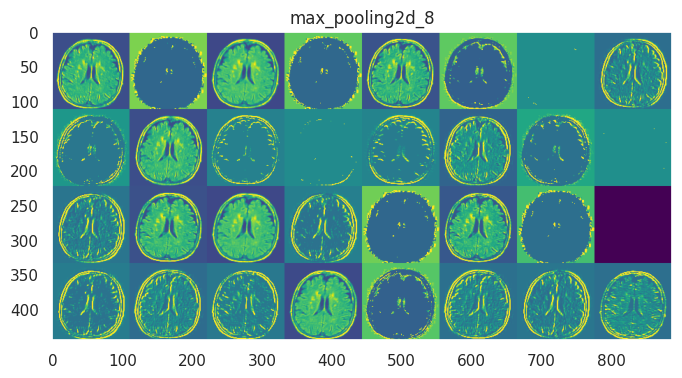

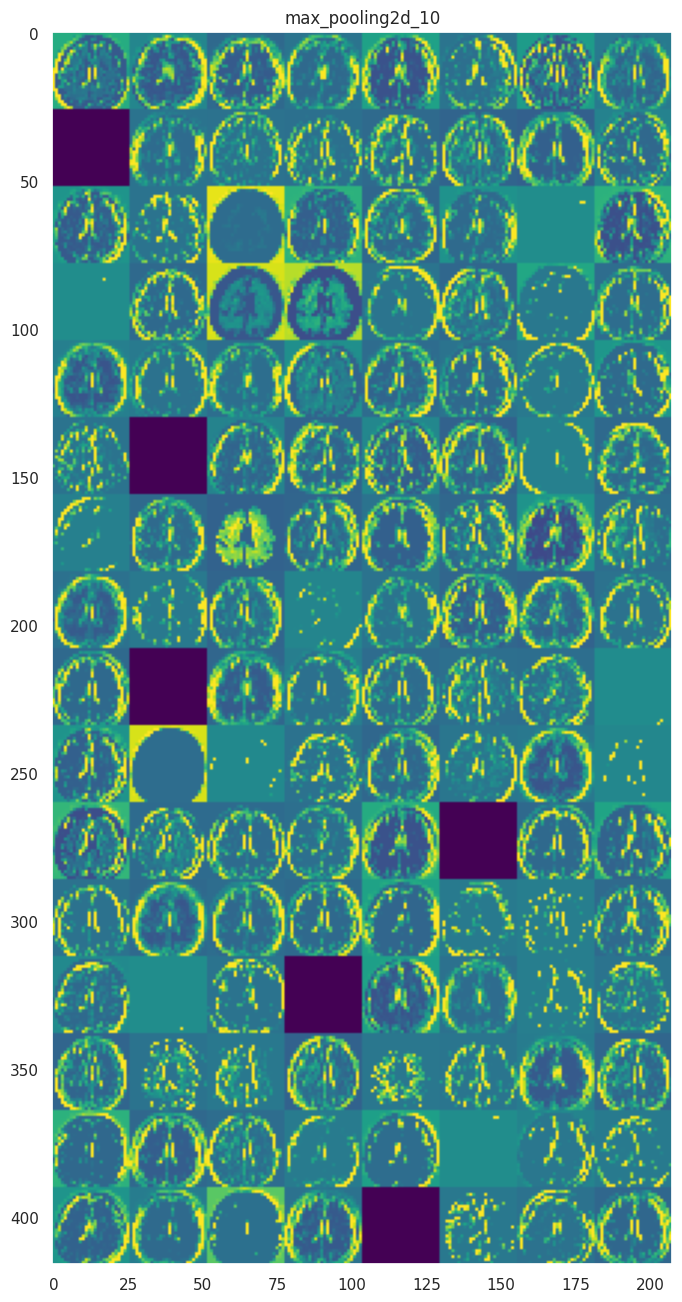

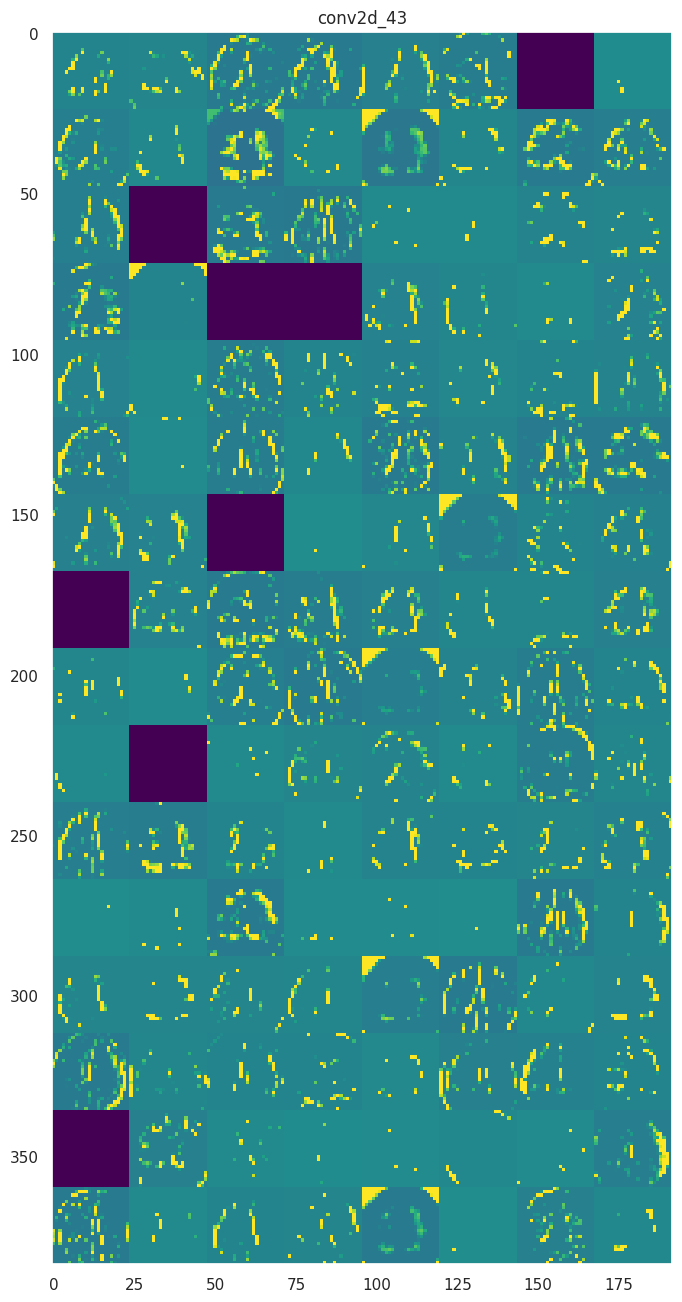

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

layer_names = [layer.name for layer in model.layers[:8]]


if not model.built:
    model.build(input_shape=(None, 150, 150, 3))


layer_outputs = [model.get_layer(name).output for name in layer_names]


activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)


if 'img_tensor' not in locals():
    print("Warning: 'img_tensor' not found. Please ensure it's defined or run previous cells.")

    img_tensor = np.random.rand(1, 150, 150, 3).astype('float32')

activations = activation_model.predict(img_tensor)


images_per_row = 8

for layer_name, layer_activation in zip(layer_names, activations):

    # layer_activation shape is (1, height, width, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # We tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Fill the grid with the filter images
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            # Post-process the feature to make it visually pleasing
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Place into grid
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

In [105]:

model.save('/content/drive/MyDrive/ML/BrainTumor.keras')

print("Model saved!")

Model saved!


In [106]:
import os
import sys
from google.colab import drive
from tensorflow.keras.models import load_model

# 1. Montăm Drive-ul
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Definim folderul unde crezi că e modelul
folder_tinta = '/content/drive/MyDrive/ML'

print(f"🔍 Caut fișiere în: {folder_tinta} ...")

try:

    fisiere = os.listdir(folder_tinta)
    gasit = False
    nume_model = ""

    for f in fisiere:
        if f.endswith('.keras') or f.endswith('.h5'):
            print(f"   -> Am găsit un posibil model: {f}")
            if 'BrainTumor' in f or 'brain' in f.lower():
                nume_model = f
                gasit = True

    if gasit:
        cale_completa = os.path.join(folder_tinta, nume_model)
        print(f"\n✅ PEREFECT! Încerc să încarc: {cale_completa}")

        global model
        model = load_model(cale_completa)
        print("🎉 MODELUL ESTE DEFINIT ȘI ÎNCĂRCAT! Acum poți face predicții.")

    else:
        print("\n❌ NU am găsit niciun fișier .keras sau .h5 în acest folder.")
        print("Te rog verifică dacă ai salvat modelul în '/content/drive/MyDrive/ML'")

except Exception as e:
    print(f"\n❌ EROARE CRITICĂ: {e}")
    print("Verifică dacă folderul '/content/drive/MyDrive/ML' există cu adevărat.")

🔍 Caut fișiere în: /content/drive/MyDrive/ML ...
   -> Am găsit un posibil model: BrainTumor.keras

✅ PEREFECT! Încerc să încarc: /content/drive/MyDrive/ML/BrainTumor.keras
🎉 MODELUL ESTE DEFINIT ȘI ÎNCĂRCAT! Acum poți face predicții.


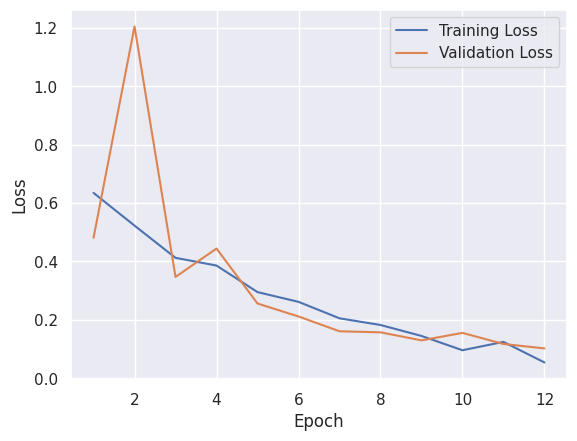

In [107]:
if 'history' in locals() and history is not None:
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: The 'history' object is not defined.")
    print("This usually happens if the model training cell (model.fit) was not executed, ")
    print("or if the kernel state was reset (e.g., by loading a new model) after training.")
    print("Please ensure the training cell (e.g., cell HH6LQ9mHSNk_ where model.fit is called) has been run recently ")
    print("and that this plotting cell is executed *before* any operations that might clear the kernel state.")

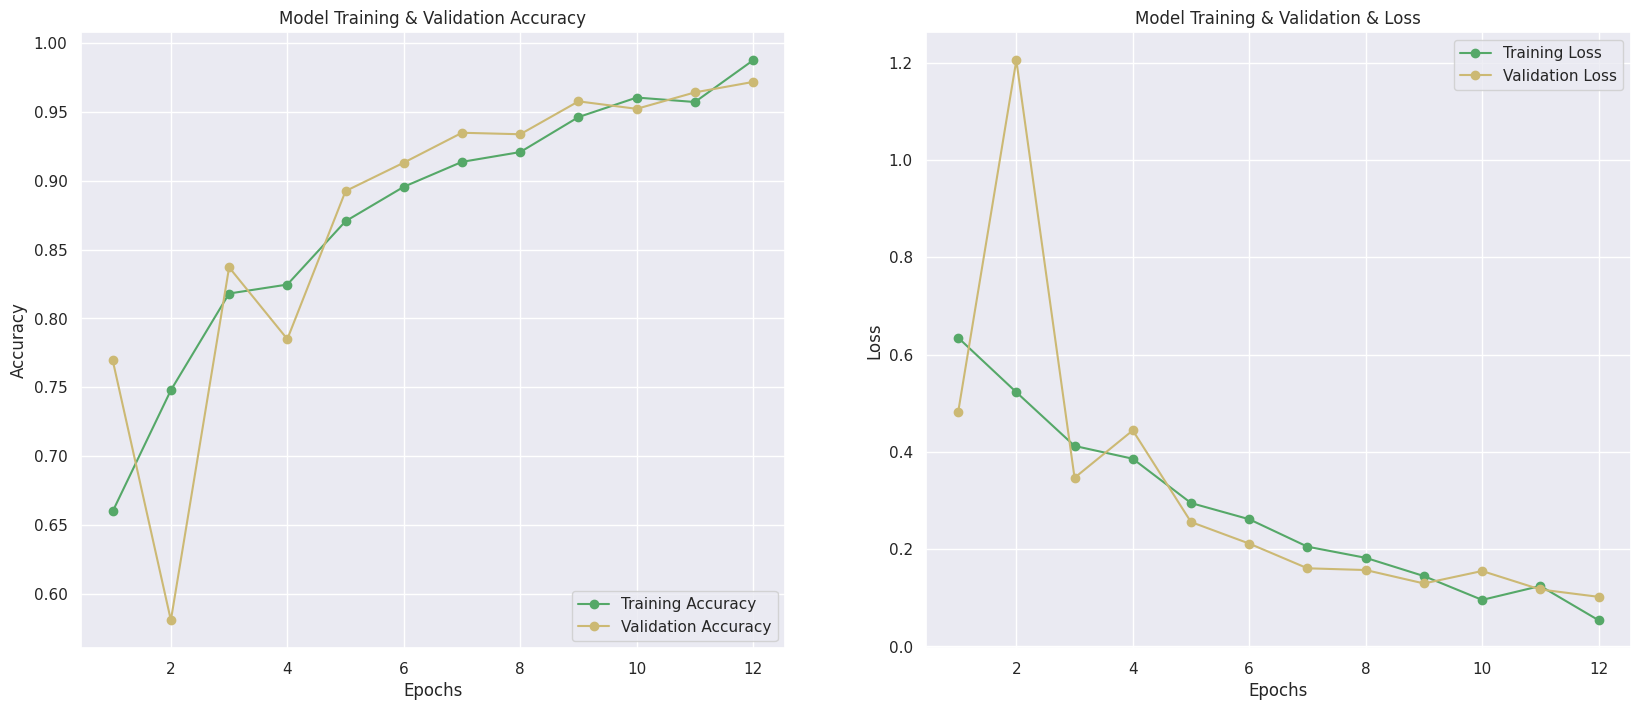

In [109]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

Se calculează predicțiile...
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step

Matricea de Confuzie (Valori):
[[493  10]
 [ 16 402]]


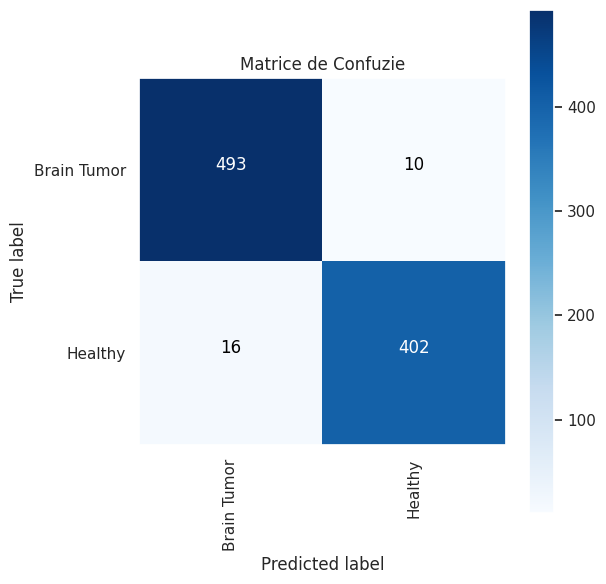

In [116]:
from sklearn.metrics import confusion_matrix
import numpy as np


test_data = validation_generator


test_data.shuffle = False
test_data.reset()


y_test = test_data.classes

# B. Facem predicția
print("Se calculează predicțiile...")
y_pred_probs = model.predict(test_data, verbose=1)


yhat_test = (y_pred_probs > 0.5).astype(int).reshape(-1)


cm = confusion_matrix(y_test, yhat_test)
print("\nMatricea de Confuzie (Valori):")
print(cm)


classes_names = list(test_data.class_indices.keys())


plot_confusion_matrix(cm, classes_names, normalize=False, title='Matrice de Confuzie')

In [117]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [119]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       503
           1       0.98      0.96      0.97       418

    accuracy                           0.97       921
   macro avg       0.97      0.97      0.97       921
weighted avg       0.97      0.97      0.97       921



In [153]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def VizGradCAM_binary(model, image, interpolant=0.5, plot_results=True):

    assert (0 < interpolant < 1), "Interpolant must be between 0 and 1"

    # convert BGR→RGB & normalize
    original_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype("float32") / 255.0

    # reshape for model
    img = np.expand_dims(original_img, axis=0)

    # prediction (sigmoid)
    pred = model.predict(img)
    prediction_idx = 0  # always 0 for binary sigmoid

    # === find last Conv2D ===
    last_conv_layer = next(
        layer for layer in reversed(model.layers)
        if isinstance(layer, Conv2D)
    )

    # === GRAD-CAM ===
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img)
        loss = preds[:, 0]  # binary classification -> one neuron

    gradients = tape.gradient(loss, conv_out)
    conv_out = conv_out[0]
    gradients = gradients[0]

    weights = tf.reduce_mean(gradients, axis=(0, 1))

    cam = np.zeros(conv_out.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_out[:, :, i]

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))
    cam = np.uint8(255 * cam)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.uint8(original_img * 255 * interpolant + heatmap * (1 - interpolant))

    if plot_results:
        plt.figure(figsize=(5,5))
        plt.imshow(overlay)
        plt.axis("off")
    else:
        return overlay
